In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from scipy.spatial.distance import cdist

# Affinity Mapping

TODO

Given the transnational nature of terrorist networks, cooperation is crucial amongst counterterrorism bodies of various objectives and governing bodies. In this notebook, we seek to develop a measure of similarity across *traits of interest* such as region or terrorist group, 

In this notebook, we seek TODO

When working in a particular counter-terrorism context, it is natural to ask whether data from completely different circumstances is useful. Why, after all, should we think that terrorist attack data from Nigeria is useful in predicting attacks in the UK? 

In light of this, we will try to divide the dataset into chunks, so that an algorithm which seeks to predict 

1. Grouping by attribute, such as region or weapon type. 

2. Grouping by clustering, after applying a clustering algorithm to the points in $\mathbb{R}^{n}$.

## Affinity Along Attributes

We will first group the data by attribute, and then calculate pairwise distances from the means of each group. For example, there are 12 regions in the dataset. If we divide the 

## Preprocessing

In [5]:
from preprocess_functions import load_data_relevant_cols, get_dummies

In [6]:
raw = load_data_relevant_cols()

/Users/akhiljalan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (4,6,8,10,11,12,17,18,24,29,31,33,35,37,38,39,41,43,45,46,47,49,51,53,54,55,57,58,59,60,61,62,63,64,73,76,79,82,84,86,88,90,92,94,96,97,106,108,114,115,121,123,125,126,127,128,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/akhiljalan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (6,61,62,63,79,94,96,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Even after eliminating useless attributes in our preprocessing, we still have a variety of traits in our data which we can use to inform a similarity measure. 

In [7]:
raw.columns.values

array(['iyear', 'imonth', 'iday', 'country', 'country_txt', 'region',
       'region_txt', 'provstate', 'city', 'latitude', 'longitude',
       'specificity', 'success', 'attacktype1', 'attacktype1_txt',
       'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt',
       'natlty1', 'natlty1_txt', 'gname', 'motive', 'weaptype1',
       'weaptype1_txt', 'weapsubtype1', 'weapsubtype1_txt', 'nkill',
       'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'property',
       'propextent', 'propextent_txt', 'propvalue', 'propcomment',
       'ransom', 'ransomamt'], dtype=object)

Of particular interest to us is similarity of different terrorist groups. However, there are over 3,000 unique terrorist groups in the database, making full-scale analyses quite difficult. Therefore, we'll first figure out what the most deadly terrorist groups are, and then restrict analysis to those.

In [12]:
len(raw['gname'].unique())

3454

## Deadliest Terrorist Groups

As a quick check, we'll first iterate through the data and figure out which groups have over 500 attacks.

In [17]:
terror_group_names = raw['gname'].unique()
for name in terror_group_names: 
    num_attacks = len(raw[raw['gname'] == name])
    if num_attacks > 500: 
        print('Group: {} has over 500 attacks'.format(name))

Group: Unknown has over 500 attacks
Group: New People's Army (NPA) has over 500 attacks
Group: Palestinians has over 500 attacks
Group: Irish Republican Army (IRA) has over 500 attacks
Group: Basque Fatherland and Freedom (ETA) has over 500 attacks
Group: National Liberation Army of Colombia (ELN) has over 500 attacks
Group: Corsican National Liberation Front (FLNC) has over 500 attacks
Group: Revolutionary Armed Forces of Colombia (FARC) has over 500 attacks
Group: Liberation Tigers of Tamil Eelam (LTTE) has over 500 attacks
Group: M-19 (Movement of April 19) has over 500 attacks
Group: African National Congress (South Africa) has over 500 attacks
Group: Shining Path (SL) has over 500 attacks
Group: Farabundo Marti National Liberation Front (FMLN) has over 500 attacks
Group: Muslim extremists has over 500 attacks
Group: Maoists has over 500 attacks
Group: Separatists has over 500 attacks
Group: Sikh Extremists has over 500 attacks
Group: Nicaraguan Democratic Force (FDN) has over 500 

From an original dataset of over 3,000 terrorist groups we have restricted our scope to under 50. To see exactly which groups have the most attacks, let's plot number of attacks against group for these groups. We can re-use code from a previous notebook, but slightly modified.

In [18]:
def get_num_attacks_tuples(attribute, min_number_attacks = 500):
    '''
    Input: 
    attribute: A string corresponding to an attribute we are interested in, 
    such as region or weapon type.
    min_number_attacks: A cutoff point for the minimum number of attacks. 
    Any category with fewer attacks will not be returned.
    
    Output: A dictionary whose keys are the different values of attribute, 
    and values are the number of attacks in that category.
    '''
    attribute_vals = raw[attribute].unique()
    out = {}
    for val in attribute_vals: 
        df_subset = raw[raw[attribute] == val]
        num_attacks = len(df_subset)
        if (num_attacks >= min_number_attacks or val == 'Unknown'):
            out[val] = num_attacks
    return sorted(out.items(), key=lambda tup: (tup[1], tup[0]), reverse=True)

In [19]:
top_terror_groups = get_num_attacks_tuples('gname')

In [32]:
def plot_count_by_attribute(num_attacks_tuples, attribute, use_xticks = True):
    '''
    See get_num_attacks_tuples. 
    
    Input: 
    num_attacks_tuples: A dictionary whose keys are the different values of attribute, 
    and values are the number of attacks in that category.
    attribute: A string corresponding to an attribute we are interested in, 
    such as region or weapon type.
    use_xticks: A boolean. The plot displays x_ticks if true.
    
    Output: A bar plot of number of attacks in the num_attacks_tuples, by key value. 
    '''
    plt.figure(figsize=(12, 6))

    y_pos = np.arange(len(num_attacks_tuples))
    plt.bar(y_pos, [x[1] for x in num_attacks_tuples], color='green')
    
    if use_xticks:
        plt.xticks(y_pos, [x[0] for x in num_attacks_tuples])
        plt.xticks(rotation=90)

    plt.ylabel('Number of Attacks')
    plt.title('Number of Terrorist Attacks by {}'.format(attribute))
    
    plt.show();

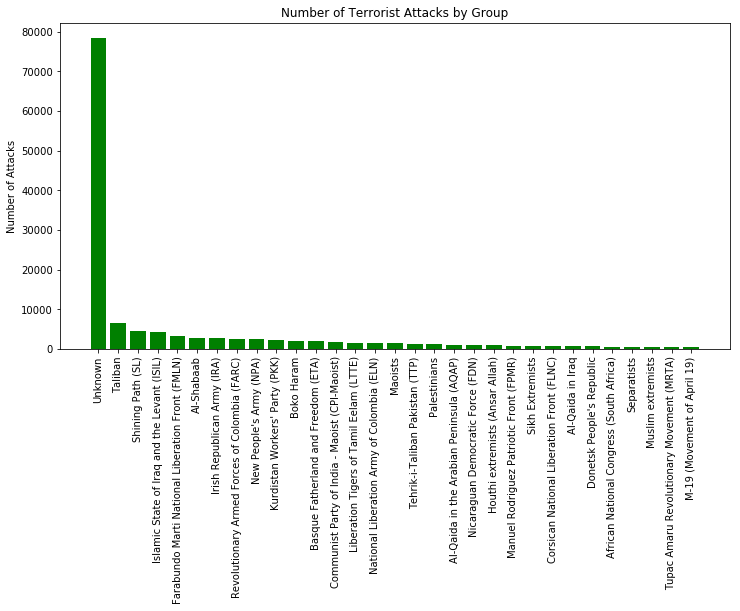

In [35]:
plot_count_by_attribute(top_terror_groups, 'Group')

Unsurprisingly, 'Unknown' is by far the deadliest terrorist group in our dataset. But to compare known groups, let's remove that value and plot again.

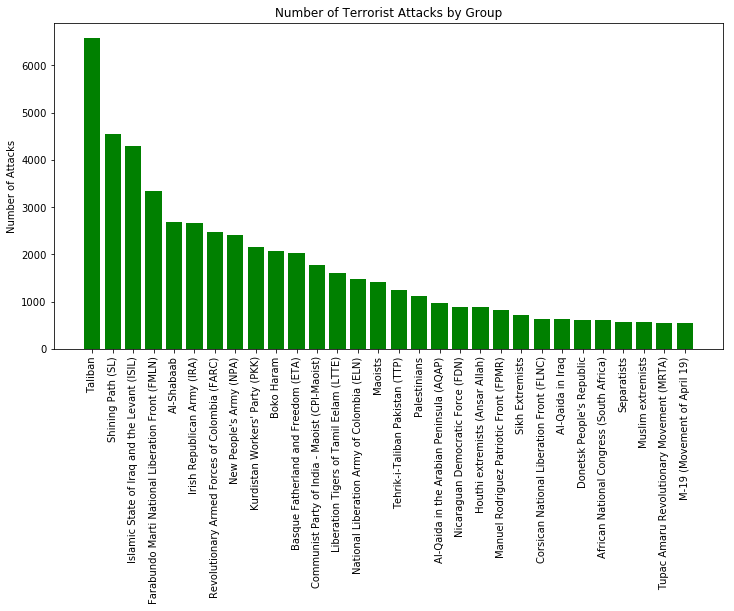

In [36]:
known_top_terror_groups = top_terror_groups[1:]
plot_count_by_attribute(known_top_terror_groups, 'Group')

Similar to the plots for number of attacks by region or weapon type in ```counter_terrorism_nb1```, we can observe an exponential decay in number of attacks by group - meaning the few deadliest groups account for the vast majority of attacks. 

## Distance Mapping

Because this is simply exploratory analysis, we will simplify the similar measure to only look at a few key attributes. Using the ```get_dummies``` function from pre-processing, we will create a one-hot encoding of the terrorist attack data with respect to these traits, and then use $\ell_2$ distance in $\mathbb{R}^{n}$ for measuring how "similar" two attacks are to one another. 

In [9]:
traits_to_compare = ['region_txt', 'targtype1_txt', 'weaptype1_txt', 
                     'iyear', 'nkill', 'natlty1_txt', 'gname']
dummies = get_dummies(raw, traits_to_compare)

3454

## Distance Mapping Explanation

The code below is somewhat involved, so it deserves some explanation. 

We want to display a heatmap which displays "affinity" of subsets of the data for one another. For example, we might divide the data by region, and then ask which regions are "similar" to one another with respect to $\ell_2$ distance in the vectorized space. 

1. For computational efficiency, we compute the distance of the means of the sub-groups rather than the average of pair-wise distances between each subgroup. Given that our dataset has over 170,000 attacks, the latter would be far too expensive to be feasible. 

2. We only display the lower triangular half of the pairwise distance matrix, because for any points $i, j$, the distance $d(i, j)$ and $d(j, i)$ are equal. We also don't display $d(i, i)$, because $d(i, i) = 0$ for all $i$. 

3. One of the arguments in the function below is ```percentile_cutoff```, which corresponds to the percentage of distance values that we want to display. Displaying distances below a certain percentile makes the heatmaps easier to read, as the goal of these is to explore which subsets of the data are most similar to one another. 

If we have $n$ regions then there are $n^{2}$ entries in the data. However, we don't display diagonal values, and only display the lower triangular half of each matrix, so we are only interested in $\frac{n(n - 1)}{2}$ of the values. In the function, we scale ```percentile_cutoff``` by $\frac{n(n - 1)}{2}$ to reflect this. 

In [131]:
def plot_affinity_heatmap(trait_str, colormap='ocean', percentile_cutoff = 0.2):     
    trait_labels = [label for label in dummies.columns.values if trait_str in label]
    trait_labels = [label for label in trait_labels if label not in [trait_str + 'Unknown', trait_str + 'Other']]
    num_subsets = len(trait_labels)
    means = []
    for label in trait_labels: 
        means.append(np.mean(dummies[dummies[label] == 1]).drop(index=trait_labels))
    plt.figure(figsize=(12, 8))
    plot_labels = [label.replace(trait_str, '')[:25] for label in trait_labels]
    distance_matrix = cdist(means, means)
    dist_df = pd.DataFrame(distance_matrix)
    cutoff = dist_df.quantile(q=percentile_cutoff * (0.5 * num_subsets * (num_subsets - 1))/(num_subsets**2))
    mask_arr = dist_df > cutoff 
    for i in range(len(mask_arr)): 
        for j in range(i + 1): 
            mask_arr[i][j] = True 
    sns.heatmap(cdist(means, means), cmap=colormap, xticklabels=plot_labels, 
                yticklabels=plot_labels, annot=True, mask=mask_arr)
    plt.title('Divergence of mean terrorist attacks: Top {} Percent'.format(int(percentile_cutoff * 100)))

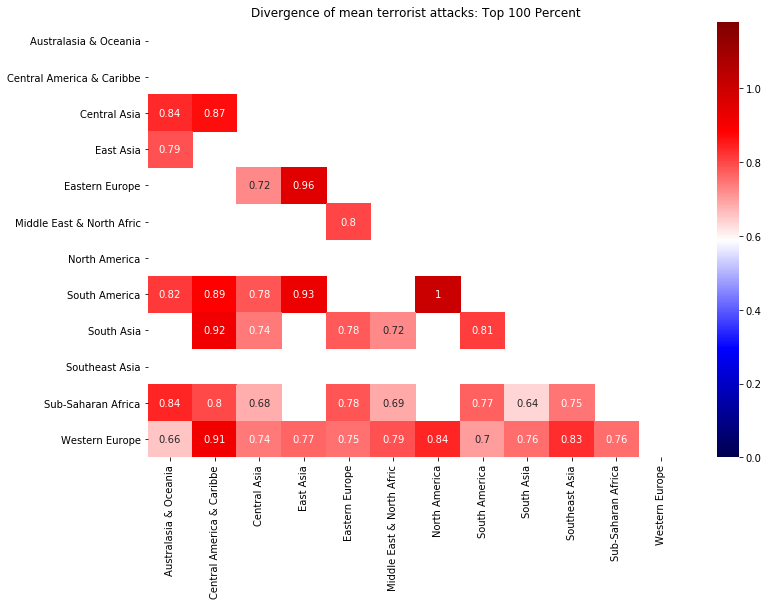

In [132]:
plot_affinity_heatmap('region_txt_', colormap='seismic', percentile_cutoff=1.0)

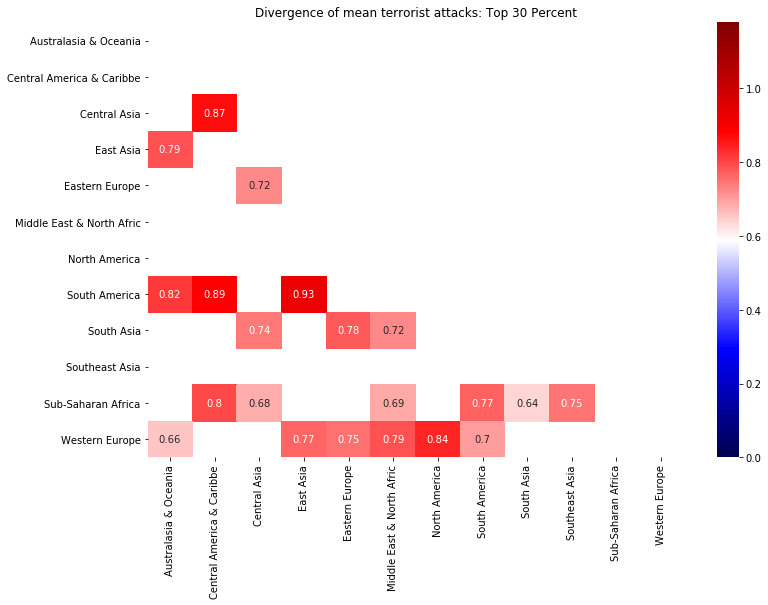

In [125]:
plot_affinity_heatmap('region_txt_', colormap='seismic', percentile_cutoff=0.3)

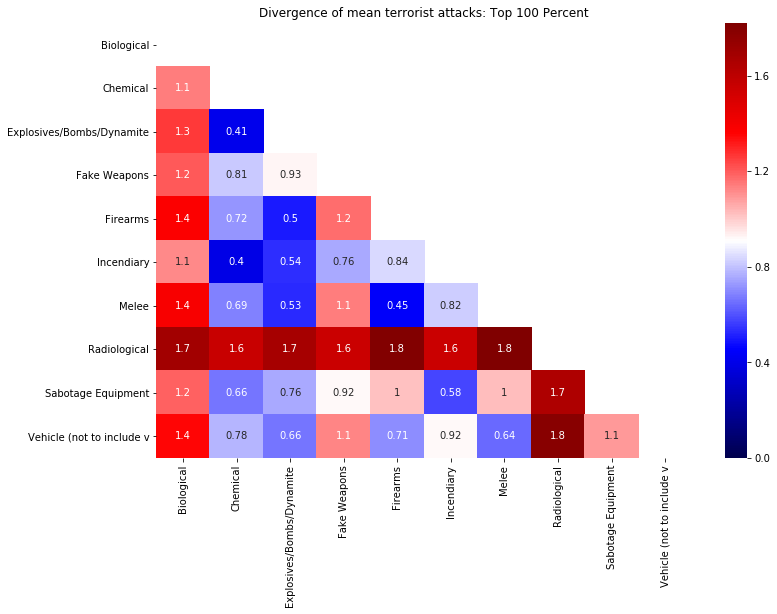

In [126]:
plot_affinity_heatmap('weaptype1_txt_', colormap='seismic', percentile_cutoff=1.0)

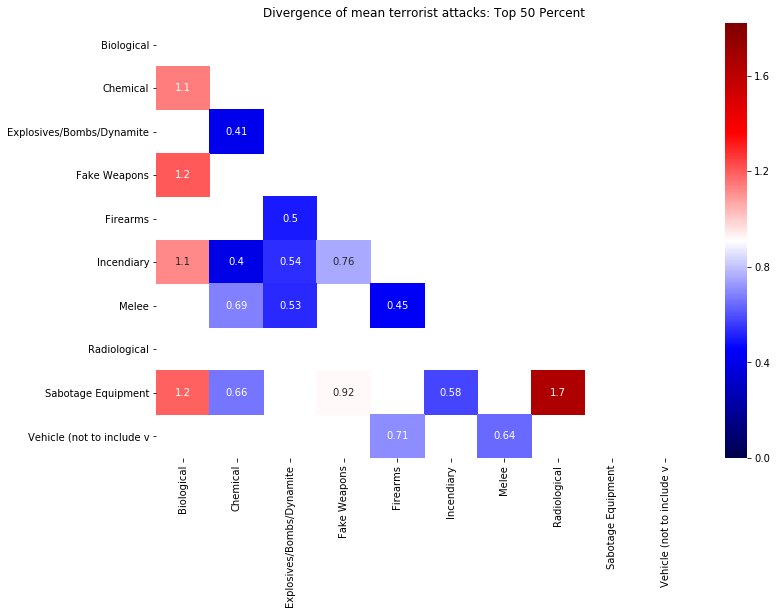

In [129]:
plot_affinity_heatmap('weaptype1_txt_', colormap='seismic', percentile_cutoff=0.25 * 2)

In [118]:
# todo: 
'''1. Preprocess the data so that it scales uniformly. Remember sqrt(2) rule 
2. k-means
3. normal clustering (DB-SCAN because of sparsity?)
4. SVM
5. k-nearest neighbors 
6. sensitivity analysis'''

l1 = ['unknown', 'hello']
l2 = ['unknown']
# [arg for arg in l1 if arg not in l2]

['hello']